In [1]:
#install.packages('deSolve')
require('deSolve')
library("deSolve")


Loading required package: deSolve
Warning message:
"package 'deSolve' was built under R version 3.6.2"

In [2]:
# most initial parameters are up here, except infusion rate (since it's interesting to change)

V_max = 0.1
e = 1e-1
K_g = 2
C = 0.0001 
K_transfer = 0.10
K_untransfer = 0.0001
K_death = 0.01

## Differential Equations

$$ \begin {aligned*}
 G = V_{max}\cdot N \cdot u(R, K_{g}) \\
 T_{s} = K_{T}\cdot N \cdot (1- u(R, K_{g})) \\
 T_n = K_R\cdot S \cdot u (R,K_g) \\ \\
\frac{dN}{dt} = G - T_s + T_n \\ \\
\frac{dR}{dt} = -e \cdot G + C \cdot (N+R) + i\\ \\ 
\frac{dS}{dt} = T_s - T_n - K_d \cdot S \\ \\
u(x,\ K)=\frac{x}{x+K}
\end {aligned*}$$

### Base variables 
$$ V_{max}$$: maximum per-bacterium growth rate 

$$ K_g $$: concentration of resource resulting in half-maximal growth rate

$$ K_t $$: Rate constant for conversion from growth to stationary phase

$$ K_R $$: Rate constant for conversion from stationary to growth phase

$$ K_d $$: Rate constant for stationary phase bacterial death due to starvation

$$ e $$: efficiency constant; amount of resource to create a new bacterium

$$ C $$: constant resource consumption per bacterium

$$ i $$: infusion rate; amount of resource influx per unit time

### Explanation of composite variables
$$ u(x, K) $$: common function used in Monod law

$$ G $$: New growth phase bacteria

$$ T_s $$: Transfers from growth to stationary phase

$$ T_n $$: Transfers from stationary to growth phase




In [3]:
# functions for ODE solving here

monod <- function(S, Ks){ # since it gets called a lot 
  return (S/(Ks+S))
}

clamp <- function(x, lower, upper){ # It's possible for a small approximation error to create a negative value, which causes issues
  if (x < lower){return(lower)}
  else if (x>upper){return(upper)}
  else{return(x)}
  
}

f <- function(t, y, params){ # Main ODE system
  N = y[1]
  R = y[2]
  S = y[3]
  i = params[1]
  
  RN = R#/(N+S)
  G <- V_max * monod(RN,K_g)*N
  T_S <- K_transfer*(1-monod(RN,K_g))*N
  T_N <- K_untransfer*monod(RN,K_g)*S
    
  dNdt <-  G - T_S + T_N
  dRdt <- -e*G +i+ C*(N+R)
  dSdt <- T_S - T_N - K_death*S  
  
  dNdt <- clamp(dNdt, lower=-N, upper=99999)
  dRdt <- clamp(dRdt, lower=-R, upper=99999)
  dSdt <- clamp(dSdt, lower=-S, upper=99999)
  
  temp <- c(dNdt, dRdt, dSdt)
  L = list(temp)
  
  return(list(temp))
}

In [4]:
# Playing with the model here. 
out = data.frame()

# Let the population grow to its normal equilibrium size
times <- seq(0,to=1000,by=0.1)
initials <- c(N=1, R=10, S=0)
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=0.1),times=times))
out <- rbind(out, out_1)

In [5]:
# Give the population some new resources
L = length(out$time)
times <- seq(out$time[L],to=out$time[L]+1000,by=0.1)
initials <- c(N=out$N[L], R=out$R[L]+20, S = out$S[L])
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=0.1),times=times))
out <- rbind(out, out_1)

In [6]:
# Remove the constant infusion of resources
L = length(out$time)
times <- seq(out$time[L],to=out$time[L]+1000,by=0.1)
initials <- c(N=out$N[L], R=out$R[L], S = out$S[L])
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=0.0),times=times))
out <- rbind(out, out_1)

In [7]:
# Bring the population back
L = length(out$time)
times <- seq(out$time[L],to=out$time[L]+1000,by=0.1)
initials <- c(N=out$N[L], R=out$R[L], S = out$S[L])
out_1 <- as.data.frame(ode(func=f,y=initials,parms = c(i=0.1),times=times))
out <- rbind(out, out_1)

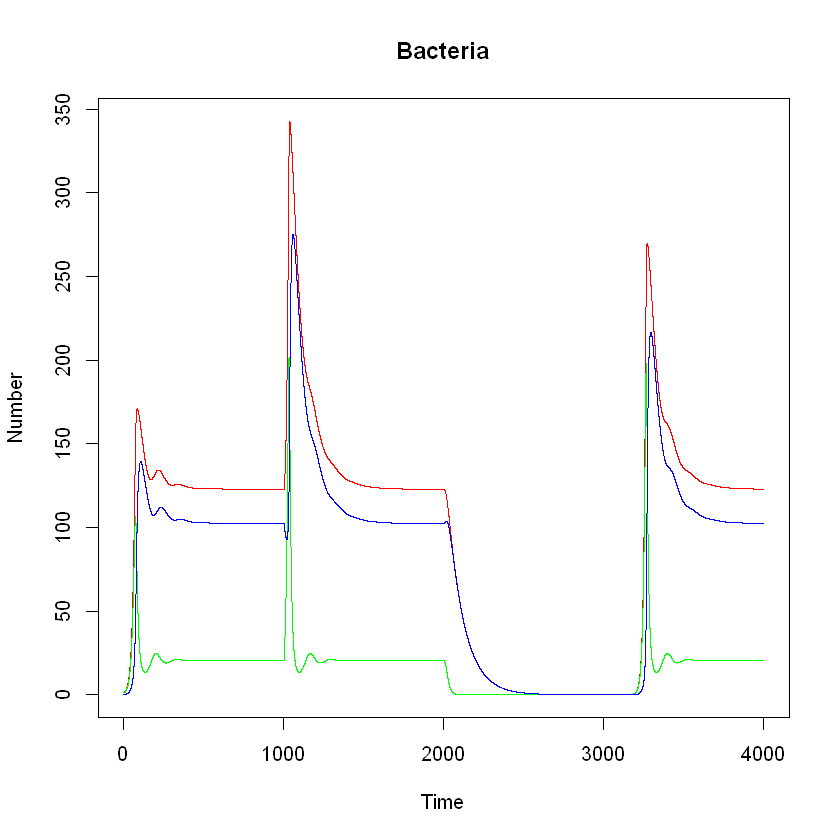

In [8]:
# Plot our populations over time (I can't make a nice legend right now; RED is total bacteria, BLUE is stationary phase, GREEN is growth phase)
plot(out$time,out$S+out$N, type='l', col='red', main='Bacteria', xlab = 'Time', ylab = 'Number')
lines(out$time,out$N, type='l', col='green')
lines(out$time, out$S, type='l', col='blue')


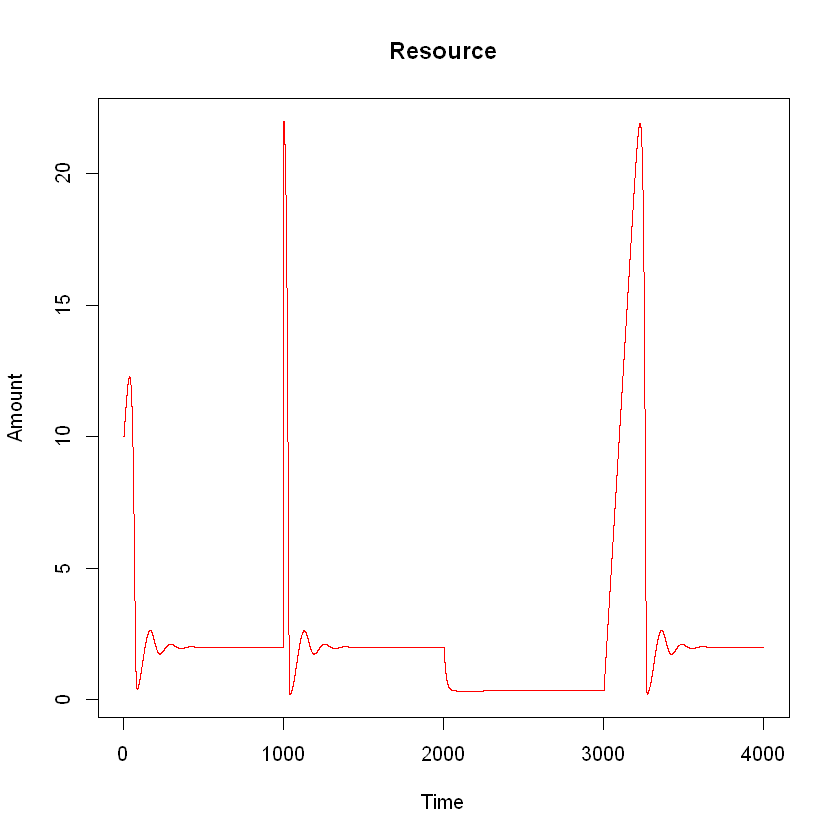

In [9]:
plot(out$time,out$R, type='l', col='red', main='Resource', xlab = 'Time', ylab = 'Amount')